### Setting Up the Environment for ARIMA Modeling

In [1]:
# Install necessary package
!pip install pmdarima

# Importing essential libraries for time series analysis, data manipulation, and visualization
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import datetime
import seaborn as sns

# Ignore warnings to keep the output clean
warnings.filterwarnings('ignore')


### Fetching and Preparing Stock Data

In [2]:
# Define the stock ticker symbol
stocks = 'AAPL'

# Set the start date  and end date for the data retrieval
startDate = int(datetime.datetime(2016, 1, 1).timestamp())
current_date = datetime.datetime.now()
endDate = int(current_date.timestamp())  # End date is the current date
interval = '1d'  # Options include '1d' for daily, '1mo' for monthly, etc.

# Initialize an empty dictionary to store stock data
stock_data = {}

# Construct the URL for fetching data from Yahoo Finance
url = f'https://query1.finance.yahoo.com/v7/finance/download/{stocks}?period1={startDate}&period2={endDate}&interval={interval}&events=history&includeAdjustedClose=true'

df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
df[:12]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.886833,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.288244,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.832502,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.868868,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,21.984501,283192000
2016-01-11,24.742500,24.764999,24.334999,24.632500,22.340475,198957600
2016-01-12,25.137501,25.172501,24.709999,24.990000,22.664717,196616800
2016-01-13,25.080000,25.297501,24.325001,24.347500,22.082001,249758400
2016-01-14,24.490000,25.120001,23.934999,24.879999,22.564949,252680400


### Verifying 'Adj Close' Column and Plotting Data

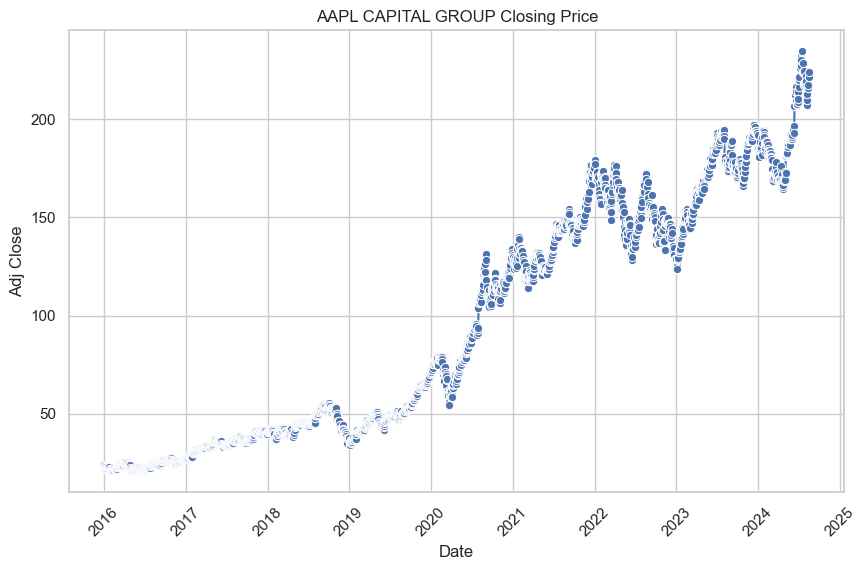

In [3]:
# Ensure the 'Adj Close' column is present in your DataFrame
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found in the DataFrame")

# Set the Seaborn style for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Adj Close', marker="o")
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('AAPL CAPITAL GROUP Closing Price')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

### Plotting Distribution of 'Adj Close' Prices

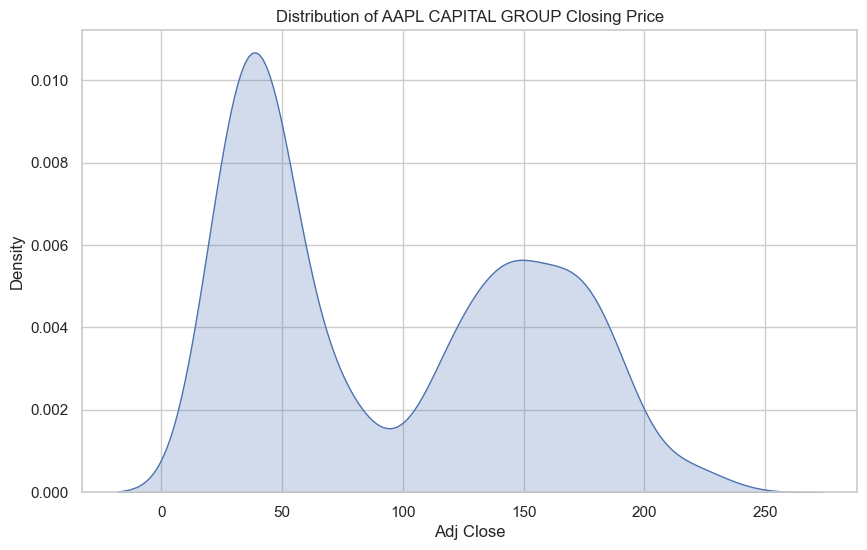

In [4]:
# Extract the 'Adj Close' column for analysis
df_close = df['Adj Close']

sns.set(style="whitegrid")

# Create and customize the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_close, shade=True)

# Add plot labels and title
plt.xlabel('Adj Close')
plt.ylabel('Density')
plt.title('Distribution of AAPL CAPITAL GROUP Closing Price')

# Display the plot
plt.show()

### Testing Stationarity of Time Series Data

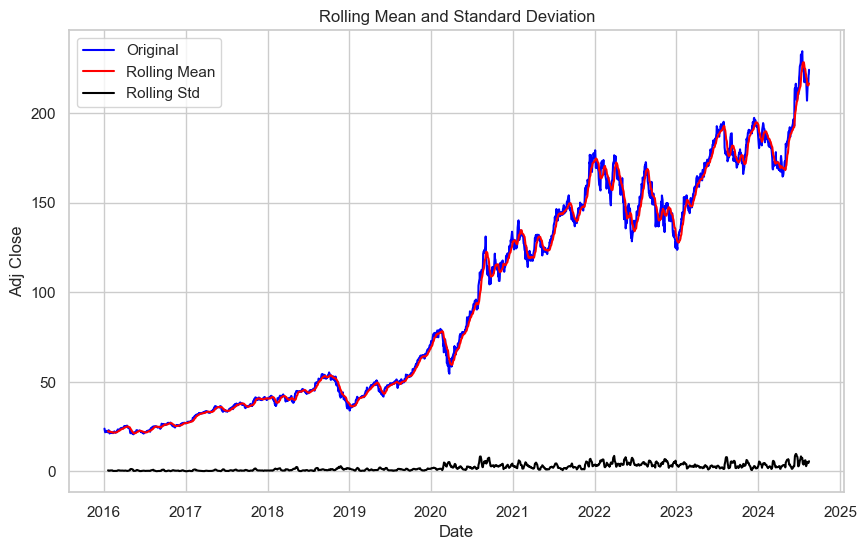

Results of Dickey-Fuller Test
Test Statistic                    0.223429
p-value                           0.973545
No. of lags used                  0.000000
Number of observations used    2168.000000
Critical Value (1%)              -3.433370
Critical Value (5%)              -2.862874
Critical Value (10%)             -2.567480
dtype: float64


In [5]:
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Set the Seaborn style for the plot
    sns.set(style="whitegrid")
    
    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=timeseries, label='Original', color='blue')
    sns.lineplot(data=rolmean, label='Rolling Mean', color='red')
    sns.lineplot(data=rolstd, label='Rolling Std', color='black')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Perform the Dickey-Fuller test for stationarity
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    
    # Output the results of the Dickey-Fuller test
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    
    print(output)

# Ensure df['Adj Close'] is a time series with a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Test stationarity on 'Adj Close' column
test_stationarity(df['Adj Close'])

### Decomposing Time Series into Components

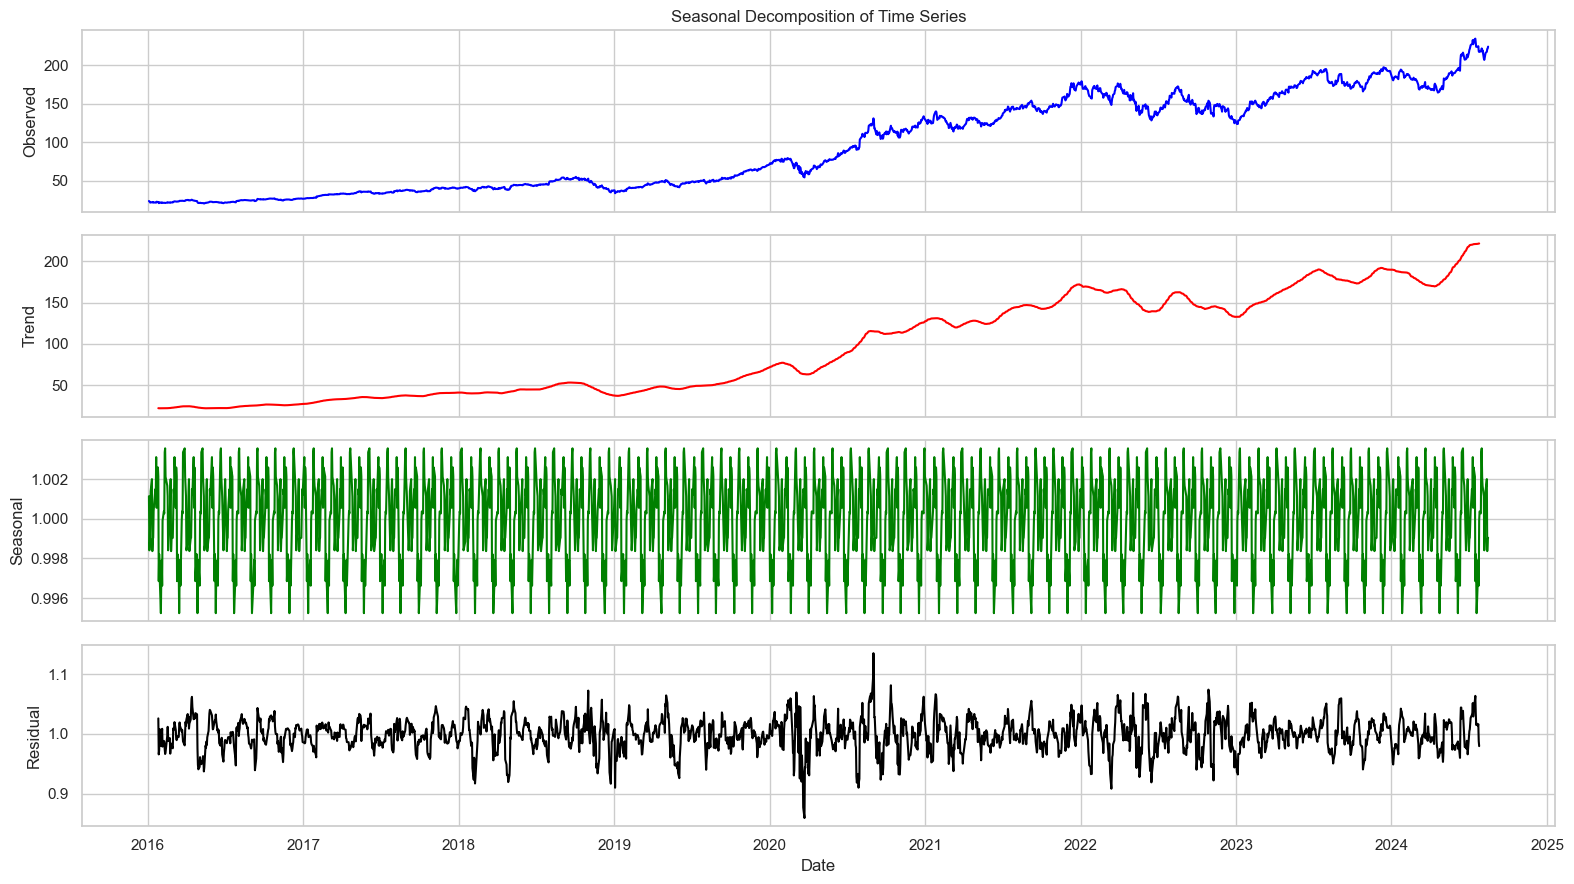

In [6]:
# Ensure the 'Adj Close' column is present in your DataFrame
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found in the DataFrame")

# Ensure df['Adj Close'] is a time series with a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Decompose the time series into its components
result = seasonal_decompose(df['Adj Close'], model='multiplicative', period=30)

# Set the Seaborn style for the plots
sns.set(style="whitegrid")

# Create subplots for decomposition components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 9), sharex=True)

# Plot the observed data
sns.lineplot(data=df['Adj Close'], ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition of Time Series')

# Plot the trend component
sns.lineplot(data=result.trend, ax=axes[1], color='red')
axes[1].set_ylabel('Trend')

# Plot the seasonal component
sns.lineplot(data=result.seasonal, ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

# Plot the residual component
sns.lineplot(data=result.resid, ax=axes[3], color='black')
axes[3].set_ylabel('Residual')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Analyzing Log-Transformed Data with Moving Average and Standard Deviation

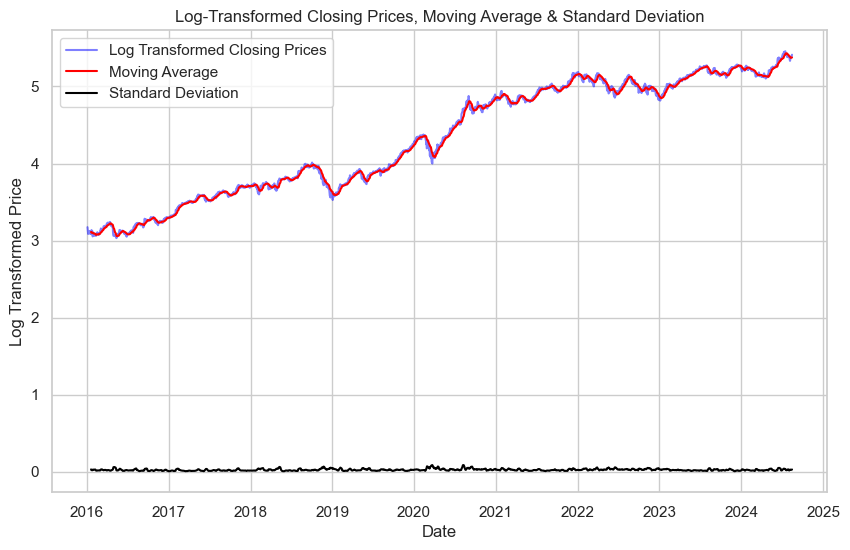

In [7]:
# Ensure the 'Adj Close' column is present in your DataFrame
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found in the DataFrame")

# Ensure df['Adj Close'] is a time series with a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Log-transform the 'Adj Close' data
df_log = np.log(df['Adj Close'])

# Calculate moving average and standard deviation of the log-transformed data
moving_avg = df_log.rolling(window=12).mean()
std_dev = df_log.rolling(window=12).std()

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Plot the log-transformed data along with moving average and standard deviation
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_log, label='Log Transformed Closing Prices', color='blue', alpha=0.5)
sns.lineplot(data=moving_avg, label='Moving Average', color='red')
sns.lineplot(data=std_dev, label='Standard Deviation', color='black')

# Add legend and title, and label the axes
plt.legend(loc='best')
plt.title('Log-Transformed Closing Prices, Moving Average & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Log Transformed Price')
plt.show()

### Plotting Log-Transformed Data with Moving Average and Testing Stationarity

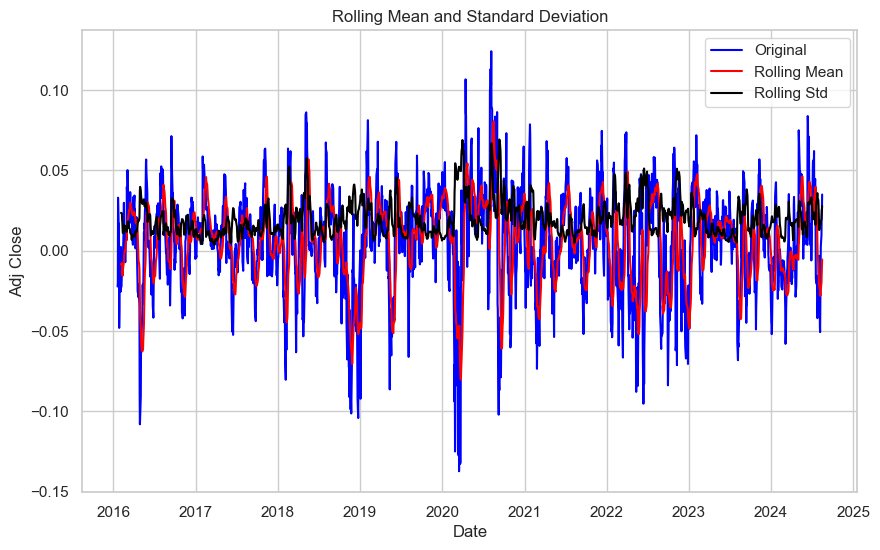

Results of Dickey-Fuller Test
Test Statistic                -9.807414e+00
p-value                        5.776492e-17
No. of lags used               1.100000e+01
Number of observations used    2.146000e+03
Critical Value (1%)           -3.433401e+00
Critical Value (5%)           -2.862888e+00
Critical Value (10%)          -2.567487e+00
dtype: float64


In [8]:
# Plot log-transformed data with moving average
data_log_minus_mean = df_log - moving_avg  # Detrend the log-transformed data
data_log_minus_mean.dropna(inplace=True)   # Drop NaN values resulting from the rolling calculation

# Test stationarity of the detrended data
test_stationarity(data_log_minus_mean)

### Splitting Data into Training and Testing Sets and Plotting

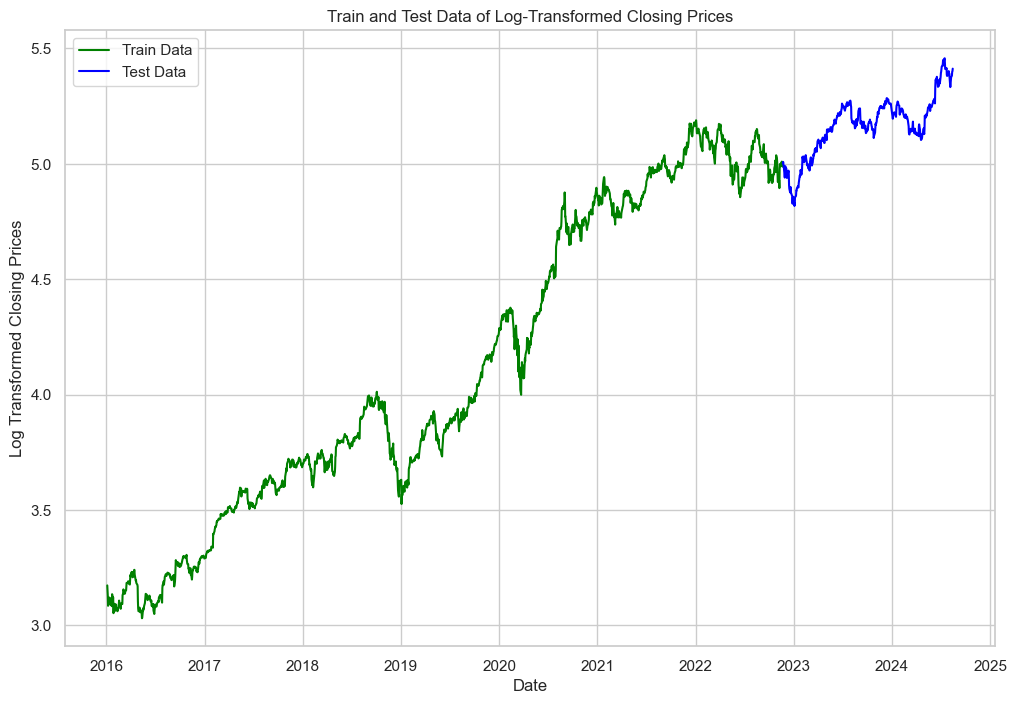

In [9]:
# Split the data into training and testing sets
train_data, test_data = df_log[:int(len(df_log) * 0.8)], df_log[int(len(df_log) * 0.8):]

# Set the plot size and style
plt.figure(figsize=(12, 8))
plt.grid(True)

# Plot the training data
plt.plot(train_data, color='green', label='Train Data')

# Plot the testing data
plt.plot(test_data, color='blue', label='Test Data')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Log Transformed Closing Prices')
plt.title('Train and Test Data of Log-Transformed Closing Prices')
plt.legend()

# Display the plot
plt.show()

### Data Preparation, Stationarity Testing, and ACF/PACF Plotting

ADF Statistic: -0.8877440745877578
p-value: 0.7919816715789315
Data is not stationary, applying differencing
ADF Statistic: -0.8877440745877578
p-value: 0.7919816715789315
Data is still not stationary after first differencing


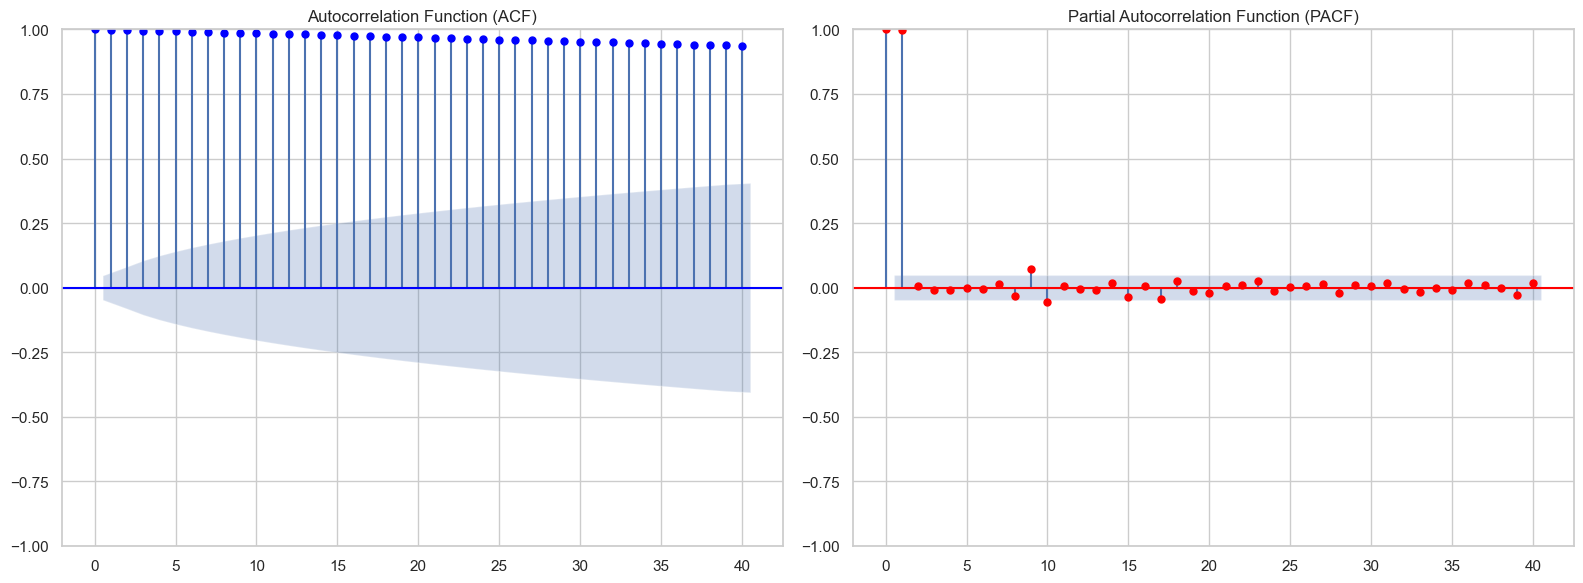

In [10]:
# Check for stationarity using the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())  # Drop NaNs for the ADF test
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
def plot_acf_pacf(data, lags=40):
    # Set the Seaborn style for the plots
    sns.set(style="whitegrid")

    # Create subplots for ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot the ACF
    plot_acf(data, lags=lags, ax=axes[0], color='blue')
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # Plot the PACF
    plot_pacf(data, lags=lags, ax=axes[1], color='red')
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Clean the data by replacing inf values and dropping NaNs
def clean_data(data):
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data

# Apply data cleaning
train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Ensure the index is a DatetimeIndex and set frequency
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)
train_data = train_data.asfreq(pd.infer_freq(train_data.index))
test_data = test_data.asfreq(pd.infer_freq(test_data.index))

# Check for stationarity of the training data
p_value = adf_test(train_data)
if p_value > 0.05:
    print("Data is not stationary, applying differencing")
    train_data_diff = train_data.dropna()  # Apply differencing
    p_value_diff = adf_test(train_data_diff)
    if p_value_diff > 0.05:
        print("Data is still not stationary after first differencing")
    else:
        print("Data is stationary after first differencing")
else:
    train_data_diff = train_data
    print("Data is already stationary")

# Plot ACF and PACF of the differenced (or original) data
plot_acf_pacf(train_data_diff)

### AutoARIMA Model Fitting and Summary

In [11]:
# Fit an AutoARIMA model to the differenced training data
model_autoARIMA = auto_arima(train_data_diff, start_p=0, start_q=0,
                      max_p=7, max_q=7,        # Maximum values for p and q
                      m=3,                     # Frequency of the series
                      d=2,                     # Differencing order
                      seasonal=False,          # No seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,              # Show the progress of the model fitting
                      error_action='ignore',   # Ignore errors during fitting
                      suppress_warnings=True,  # Suppress warnings
                      stepwise=True)           # Use stepwise search for optimal parameters

# Print the summary of the fitted AutoARIMA model
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-7439.601, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-8050.355, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-7441.601, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-8261.043, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-8389.169, Time=0.15 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-8500.504, Time=0.16 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-8527.590, Time=0.48 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=-8614.717, Time=0.81 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=-8613.774, Time=0.79 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=-8680.291, Time=2.20 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-8693.333, Time=1.82 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-8768.447, Time=1.57 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-8734.139, Time=1.24 sec
 ARIMA(4,2,2)(0,0,0)[0] i

### Plotting Diagnostics for AutoARIMA Model

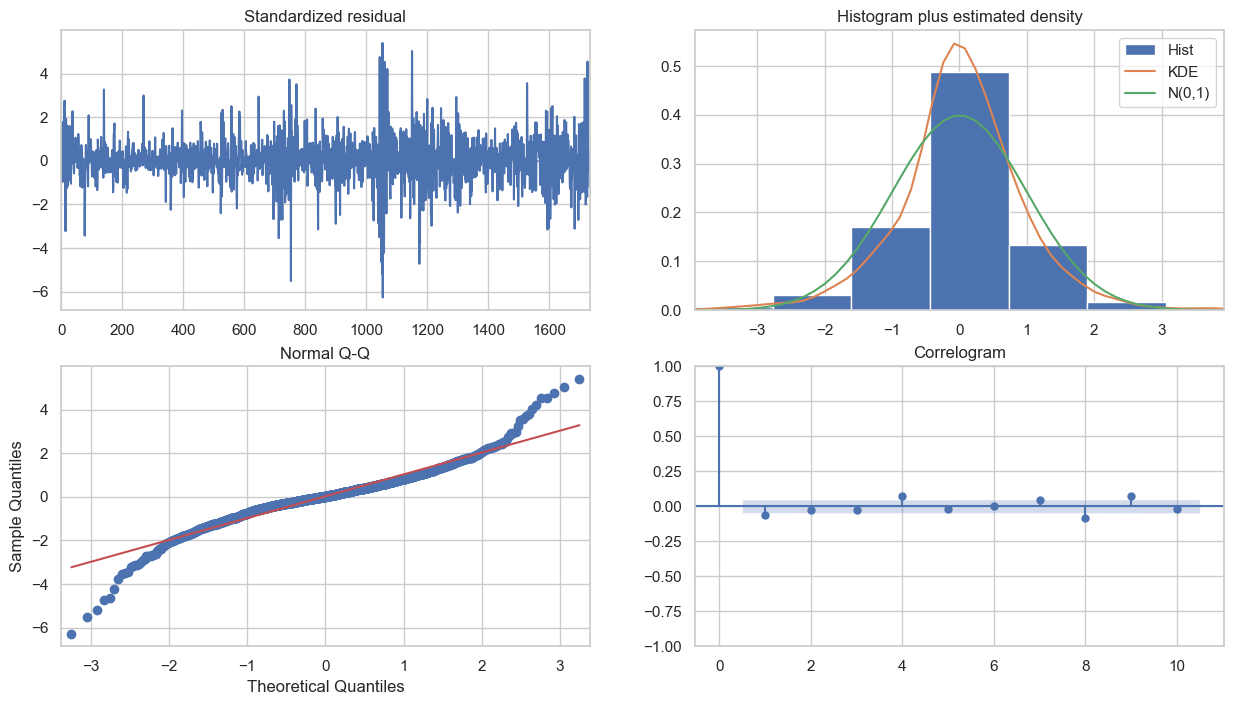

In [12]:
# Plot diagnostics for the fitted AutoARIMA model
model_autoARIMA.plot_diagnostics(figsize=(15,8))

# Display the plot
plt.show()

### Fitting ARIMA Model, Forecasting, and Plotting Results

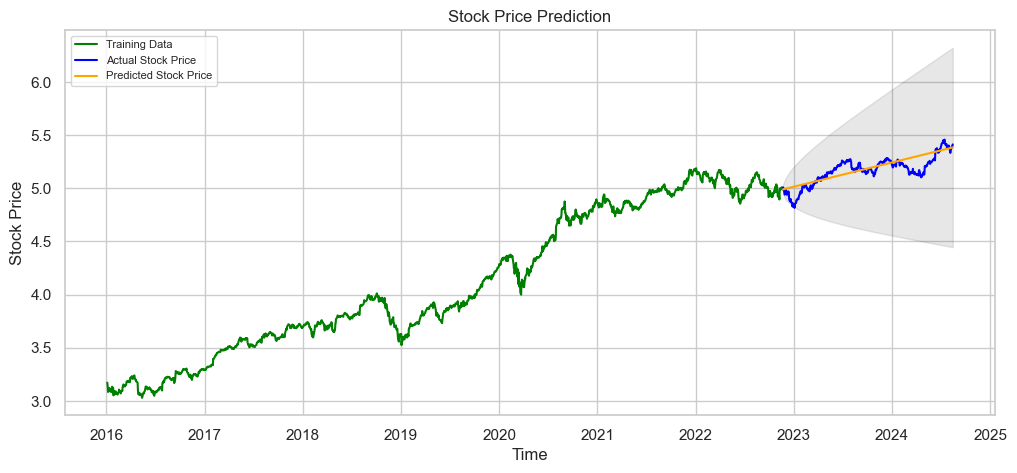

In [13]:
# Define and fit the ARIMA model using parameters from AutoARIMA
model = ARIMA(train_data, order=model_autoARIMA.order)
fitted = model.fit()

# Forecast using the fitted ARIMA model
forecast_result = fitted.get_forecast(steps=len(test_data))

# Extract forecasted mean and confidence intervals
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int(alpha=0.05)

# Convert forecast and confidence intervals to pandas Series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Plot the results
plt.figure(figsize=(12, 5), dpi=100)

# Plot the training data
sns.lineplot(x=train_data.index, y=train_data, label='Training Data', color='green')

# Plot the actual stock price
sns.lineplot(x=test_data.index, y=test_data, label='Actual Stock Price', color='blue')

# Plot the predicted stock price
sns.lineplot(x=fc_series.index, y=fc_series, label='Predicted Stock Price', color='orange')

# Fill the confidence intervals with shaded area
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.1)

# Add labels, title, and legend
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)

# Display the plot
plt.show()


### Handling NaN Values and Calculating Error Metrics

In [14]:
# Check for and handle NaN values in the test data and forecast series
test_data = test_data.dropna()
fc_series = fc_series.dropna()

# Align the test data and forecast series to have a common index
common_index = test_data.index.intersection(fc_series.index)
test_data = test_data.loc[common_index]
fc_series = fc_series.loc[common_index]

# Calculate error metrics
mse = np.mean((fc_series - test_data) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(fc_series - test_data))  # Mean Absolute Error
rmse = np.sqrt(mse)                         # Root Mean Squared Error

# Calculate Mean Absolute Percentage Error (MAPE), adding a small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((fc_series - test_data) / (test_data + epsilon))) * 100  # MAPE

# Print the calculated error metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 0.006534055426550887
MAE: 0.06255556807739292
RMSE: 0.08083350435649123
MAPE: 1.2177808050023529


### Creating and Displaying Comparison DataFrame

In [15]:
import pandas as pd

# Create a DataFrame to compare actual and forecasted values
comparison_df = pd.DataFrame({
    'Date': test_data.index,             # Index from test data as 'Date'
    'Actual': test_data.values,          # Actual values from test data
    'Forecasted': fc_series.values      # Forecasted values from the model
})

# Set the 'Date' column as the index
comparison_df.set_index('Date', inplace=True)

# Display the DataFrame
print(comparison_df)

              Actual  Forecasted
Date                            
2022-11-22  5.002473    4.989373
2022-11-23  5.008382    4.990920
2022-11-25  4.988594    4.991776
2022-11-28  4.961978    4.992999
2022-11-29  4.940603    4.994180
...              ...         ...
2024-08-09  5.375232    5.380241
2024-08-12  5.382337    5.382113
2024-08-13  5.399384    5.382737
2024-08-14  5.401415    5.383361
2024-08-15  5.412538    5.383985

[434 rows x 2 columns]
